# FC-CNN vs FCNN
My model with fully connected layers at the end of a CNN will train very quickly to determine if there is a dot in each region, but the fully convolutional one will not.  This notebook is a comparision of the 2 methods side by side

This notebook builds 2 models, trains and test them on the same exact data, and records how they perform. There are stark differences between the FC-CNN and FCNN models. The FC-CNN model trains very quickly and achieves nearly 100% accuracy very quickly. The FCNN model does not train at all. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [2]:
batch_size = 16
batch_size_testing = 4
num_classes = 6
bboxes = 1

grid_cells = 2
num_filters_last = 1
batches_per_epoch = 100

# find out how big the large images need to be
# The network needs to follow this same pattern
# It is set up so there is never any padding when using valid 3x3 conv with stride 1
outsize = grid_cells
outsize = outsize+2
outsize = outsize+2
outsize = outsize*2

outsize = outsize+2
outsize = outsize+2
outsize = outsize*2

outsize = outsize+2
outsize = outsize+2
outsize = outsize*2

outsize = outsize+2
outsize = outsize+2
large_image_shape = np.array([outsize,outsize])
pixles_per_grid_cell = (large_image_shape/grid_cells).astype(np.int)

print("large_image_shape: {}".format(large_image_shape))
print("pixles_per_grid_cell: {}".format(pixles_per_grid_cell))

large_image_shape: [76 76]
pixles_per_grid_cell: [38 38]


In [3]:
# generator for the dataset
def generate_inputs(batch_size,output_size,grid_cells,num_filters_last,num_classes):
    '''
    batch_size: number of images per batch
    output size: np.array with shape 2, height x width in pixels
    num_filters_last: the number of outputs the model has
    num_classes: the number of bins to put the dot size into for prediction
    '''
    
    pixels_per_cell = np.round(output_size[0]/grid_cells-0.5)
    pixel_width = 1./pixels_per_cell
    
    p_keep = .5
    size_min = 3#int(pixels_per_cell/4-2)
    size_max = int(pixels_per_cell/4)
    
    while True:
        x = np.random.uniform(0,0.75,size=(batch_size,1,output_size[0],output_size[1])).astype(np.float32)
        x = x*(np.random.uniform(0,1,size=x.shape)>.5).astype(np.float32)
        #x = np.zeros((batch_size,1,output_size[0],output_size[1]),dtype = np.float32)
        y = np.zeros((batch_size,num_filters_last,grid_cells,grid_cells),dtype = np.float32)
        
        for ii in range(batch_size):
            for cr in range(grid_cells): # grid row
                for cc in range(grid_cells): # grid columns
                    if np.random.uniform(0,1) > p_keep:
                        continue
                    size = np.random.randint(size_min,size_max)
                    loc = np.random.rand(2)
                    offset = (size/2. +.5)*pixel_width
                    # scale to (offset,1-offset), eqn is simplified because starts on range (0,1)
                    loc = offset + loc*(1-2*offset)                    
                    row = int(pixels_per_cell*(cr+loc[0])-size/2)
                    col = int(pixels_per_cell*(cc+loc[1])-size/2)
                    x[ii,:,row:row+size,col:col+size] = 1.
                    y[ii,0,cr,cc] = 1.
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        yield (x,y)

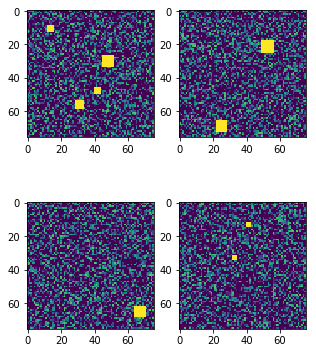

In [4]:
# What does the data set look like?
plt.rcParams['figure.figsize'] = (5,10)
n_cols = 2
n_rows = int(batch_size_testing/2 + 1)
counter = 0
for (img,lab) in generate_inputs(batch_size_testing,large_image_shape,grid_cells,num_filters_last,num_classes):
    counter = 0
    img = img.numpy()
    lab = lab.numpy()
    for ii in range(batch_size_testing):
        counter += 1
        plt.subplot(n_rows,n_cols,counter)
        plt.imshow(img[ii,0,:,:])
    plt.show()
    break

In [5]:
# define the 2 models
class fully_connected(nn.Module):
    def __init__(self,grid_cells):
        super(fully_connected,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv4_bn = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv6 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv6_bn = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.fc1 = nn.Linear(6*6*self.conv6.out_channels,64)
        self.fc2 = nn.Linear(64,4)
        
    def forward(self,x):
        
        batch_size = x.size()[0]
        self.input = x
        
        self.conv1_act = F.leaky_relu(self.conv1(x))
        self.conv2_act = F.leaky_relu(self.conv2_bn(self.conv2(self.conv1_act)))
        x = self.pool1(self.conv2_act)
        
        self.conv3_act = F.leaky_relu(self.conv3(x))
        self.conv4_act = F.leaky_relu(self.conv4_bn(self.conv4(self.conv3_act)))
        x = self.pool2(self.conv4_act)
        
        self.conv5_act = F.leaky_relu(self.conv5(x))
        self.conv6_act = F.leaky_relu(self.conv6_bn(self.conv6(self.conv5_act)))
        x = self.pool3(self.conv6_act)
        
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = x.view(batch_size,1,2,2)
        
        return x
    
class convolutional(nn.Module):
    def __init__(self,grid_cells):
        super(convolutional,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv4_bn = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv6 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1)
        self.conv6_bn = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv7 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.conv8 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1,stride=1)
        self.conv9 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1)
        self.conv10 = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1,stride=1)
        
        
    def forward(self,x):
        
        batch_size = x.size()[0]
        self.input = x
        
        self.conv1_act = F.leaky_relu(self.conv1(x))
        self.conv2_act = F.leaky_relu(self.conv2_bn(self.conv2(self.conv1_act)))
        x = self.pool1(self.conv2_act)
        
        self.conv3_act = F.leaky_relu(self.conv3(x))
        self.conv4_act = F.leaky_relu(self.conv4_bn(self.conv4(self.conv3_act)))
        x = self.pool2(self.conv4_act)
        
        self.conv5_act = F.leaky_relu(self.conv5(x))
        self.conv6_act = F.leaky_relu(self.conv6_bn(self.conv6(self.conv5_act)))
        x = self.pool3(self.conv6_act)
        
        self.conv7_act  = F.leaky_relu(self.conv7(x))
        self.conv8_act  = F.leaky_relu(self.conv8(self.conv7_act))
        self.conv9_act  = F.leaky_relu(self.conv9(self.conv8_act))
        self.conv10_act = F.leaky_relu(self.conv10(self.conv9_act))
        x = F.sigmoid(self.conv10_act)
        
        return x
    
if torch.cuda.is_available():        
    conv = convolutional(grid_cells=grid_cells).cuda()
    connected = fully_connected(grid_cells=grid_cells).cuda()
else:
    conv = convolutional(grid_cells=grid_cells)
    connected = fully_connected(grid_cells=grid_cells)
print("Fully Convolutional: \n{}".format(conv))
print("\nFully Connected: \n{}".format(connected))

Fully Convolutional: 
convolutional (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10

In [6]:
def loss_function(pred,truth):
    batch_size,depth,grid_cells,grid_cells = pred.size()
    conf = truth[:,0,:,:].contiguous()
    
    # mean squared error 
    obj_loss = (pred[:,0,:,:] - conf)**2
    obj_loss = obj_loss.view(-1).sum(dim=-1,keepdim=False)/(conf.view(-1).sum(dim=-1,keepdim=False)+1e-6)

    return obj_loss

# Function to do the testing of the nets
def test_network(net,gen,iters):
    batch_counter = 0
    loss = 0
    for img_data in gen:
        batch_counter += 1
        if batch_counter > iters:
            break
        inputs, labels = img_data
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = net(inputs)
        loss += loss_function(outputs,labels).cpu().data.numpy()[0]
    return loss/batch_counter

In [7]:
# some history trackers
hist_train_loss_conv = []
hist_train_loss_connected = []
hist_test_loss_conv = []
hist_test_loss_connected = []
weight_norm_conv = []
weight_norm_connected = []
grad_norm_conv = []
grad_norm_connected = []

# both optimizers are the same
optimizer_conv = optim.Adam(conv.parameters(),lr = 0.001, betas=(0.9,0.99),weight_decay=0)
optimizer_connected = optim.Adam(connected.parameters(),lr = 0.001, betas=(0.9,0.99),weight_decay=0)

# Generators for data:
train_gen = generate_inputs(batch_size,large_image_shape,grid_cells,num_filters_last,num_classes)
test_gen = generate_inputs(batch_size,large_image_shape,grid_cells,num_filters_last,num_classes)

print_every = 10
for epoch in range(20):
    print("epoch: {}".format(epoch))
    
    running_loss_conv = 0
    running_loss_connected = 0
    batch_counter = 0
    
    for img_data in train_gen:
        batch_counter += 1
        if batch_counter > batches_per_epoch:
            break
        
        inputs, labels = img_data
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        optimizer_conv.zero_grad()
        optimizer_connected.zero_grad()
        
        outputs_conv = conv(inputs)
        outputs_connected = connected(inputs)
        
        loss_conv = loss_function(outputs_conv,labels)
        loss_connected = loss_function(outputs_connected,labels)
        
        loss_conv.backward()
        loss_connected.backward()
        
        # Save the gradient and weights norms
        gn = []
        wn = []
        for c in conv.children():
            if "Conv" in str(c) and batch_counter > 1:
                wn.append(torch.norm(c.weight).cpu().data.numpy()[0])
                gn.append(torch.norm(c.weight.grad).cpu().data.numpy()[0])
        weight_norm_conv.append(wn)
        grad_norm_conv.append(gn)
        gn = []
        wn = []
        for c in connected.children():
            if "Conv" in str(c) and batch_counter > 1:
                wn.append(torch.norm(c.weight).cpu().data.numpy()[0])
                gn.append(torch.norm(c.weight.grad).cpu().data.numpy()[0])
        weight_norm_connected.append(wn)
        grad_norm_connected.append(gn)
        
        optimizer_conv.step()
        optimizer_connected.step()
        
        hist_train_loss_conv.append(loss_conv.cpu().data.numpy()[0])
        hist_train_loss_connected.append(loss_connected.cpu().data.numpy()[0])
        
        running_loss_conv += loss_conv.data[0]
        running_loss_connected += loss_connected.data[0]
        
        if batch_counter % print_every == 0:
            print("\rIteration: {:4}  Conv Loss: {:.5f} Connected Loss: {:.5f}  Diff: {:.5f}".format(batch_counter,
                                                                                                    running_loss_conv/print_every,
                                                                                                    running_loss_connected/print_every,
                                                                                                    (running_loss_conv-running_loss_connected)/print_every), 
                 end = "")
            running_loss_conv = 0
            running_loss_connected = 0
    
    hist_test_loss_conv.append(test_network(conv,test_gen,100))
    hist_test_loss_connected.append(test_network(connected,test_gen,100))
    print("\nTesting:\t Conv Loss: {:.5f} Connected Loss: {:.5f}\n".format(hist_test_loss_conv[-1],hist_test_loss_connected[-1]))

epoch: 0
Iteration:  100  Conv Loss: 0.44965 Connected Loss: 0.08031  Diff: 0.369346
Testing:	 Conv Loss: 0.46105 Connected Loss: 0.06991

epoch: 1
Iteration:  100  Conv Loss: 0.47158 Connected Loss: 0.01891  Diff: 0.45267
Testing:	 Conv Loss: 0.45811 Connected Loss: 0.01349

epoch: 2
Iteration:  100  Conv Loss: 0.38701 Connected Loss: 0.01583  Diff: 0.37119
Testing:	 Conv Loss: 0.42913 Connected Loss: 0.01162

epoch: 3
Iteration:  100  Conv Loss: 0.37909 Connected Loss: 0.00982  Diff: 0.36927
Testing:	 Conv Loss: 0.38272 Connected Loss: 0.00876

epoch: 4
Iteration:  100  Conv Loss: 0.36112 Connected Loss: 0.00124  Diff: 0.35988
Testing:	 Conv Loss: 0.36689 Connected Loss: 0.00305

epoch: 5
Iteration:  100  Conv Loss: 0.37413 Connected Loss: 0.00352  Diff: 0.37061
Testing:	 Conv Loss: 0.36103 Connected Loss: 0.00488

epoch: 6
Iteration:  100  Conv Loss: 0.37392 Connected Loss: 0.00396  Diff: 0.36996
Testing:	 Conv Loss: 0.36320 Connected Loss: 0.00429

epoch: 7
Iteration:  100  Conv Lo

## What do the results look like?  
*  What does the training history look like?
*  What does the test history look like?
*  Look at curve created by varying the 'cut off' for a correct prediction. Where is it the highest? 
*  What do the activations look like?


In [8]:
def moving_average(a,n=10):
    ret = np.cumsum(a,dtype=np.float32,axis = 0)
    ret[n:] = ret[n:]-ret[:-n]
    return ret[n-1:]/n

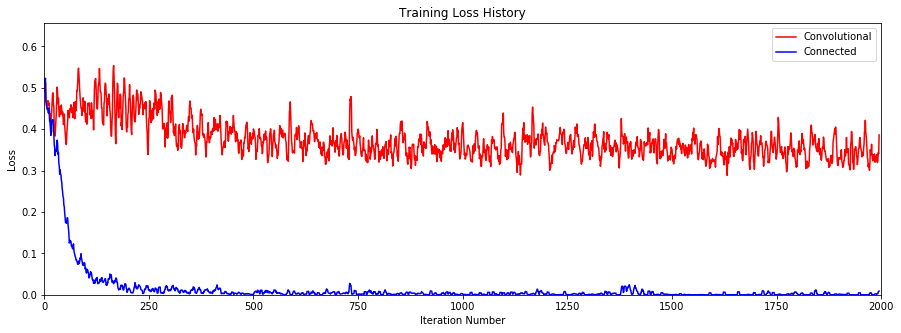

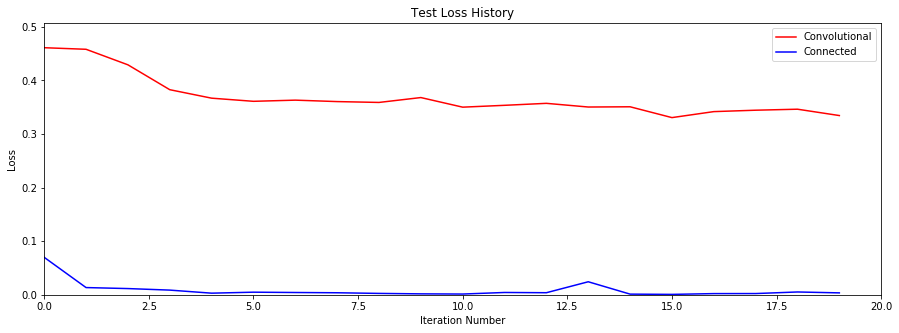

In [9]:
# Training loss history
plt.rcParams['figure.figsize'] = (15,5)
ma_count = 5 # how long to average over

plt.plot(moving_average(hist_train_loss_conv,n=ma_count),'r',label="Convolutional")
plt.plot(moving_average(hist_train_loss_connected,n=ma_count),'b',label="Connected")

plt.axis([0,len(hist_train_loss_conv), 0, 0.9*max(hist_train_loss_conv+hist_train_loss_connected)])
plt.title("Training Loss History")
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

# Test loss history
plt.plot(hist_test_loss_conv,'r',label="Convolutional")
plt.plot(hist_test_loss_connected,'b',label="Connected")

plt.axis([0,len(hist_test_loss_conv), 0, 1.1*max(hist_test_loss_conv+hist_test_loss_connected)])
plt.title("Test Loss History")
plt.xlabel("Iteration Number")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

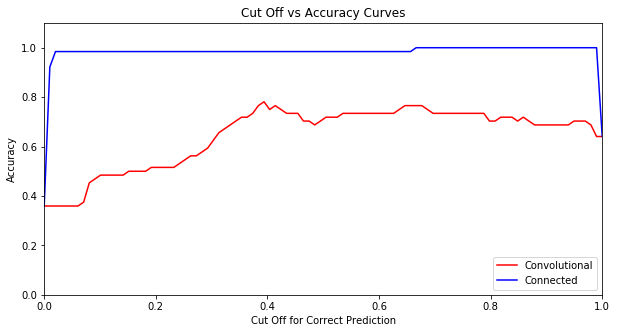

In [10]:
plt.rcParams['figure.figsize'] = (10,5)
sample_points = np.linspace(0,1,100)
accuracy = np.zeros((2,sample_points.shape[0]))

if str(type(outputs_conv)) == "<class 'torch.autograd.variable.Variable'>":
    outputs_conv =  outputs_conv.cpu().data.numpy()
if str(type(outputs_connected)) == "<class 'torch.autograd.variable.Variable'>":
    outputs_connected =  outputs_connected.cpu().data.numpy()
if str(type(labels)) == "<class 'torch.autograd.variable.Variable'>":
    labels =  labels.cpu().data.numpy()
    
for ii in range(sample_points.shape[0]):
    
    det_pred = (outputs_conv[:,0,:,:]>sample_points[ii]).astype(np.float32)
    pred_correct = (det_pred == labels[:,0,:,:]).astype(np.float32)
    accuracy[0,ii] = pred_correct.flatten().sum()/labels[:,0,:,:].flatten().shape[0]
    
    det_pred = (outputs_connected[:,0,:,:]>sample_points[ii]).astype(np.float32)
    pred_correct = (det_pred == labels[:,0,:,:]).astype(np.float32)
    accuracy[1,ii] = pred_correct.flatten().sum()/labels[:,0,:,:].flatten().shape[0]
    
plt.plot(sample_points,accuracy[0,:],'r',label="Convolutional")
plt.plot(sample_points,accuracy[1,:],'b',label="Connected")
plt.legend(loc="lower right")
plt.title("Cut Off vs Accuracy Curves")
plt.xlabel("Cut Off for Correct Prediction")
plt.ylabel("Accuracy")
plt.axis([0,1,0,1.1])
plt.show()

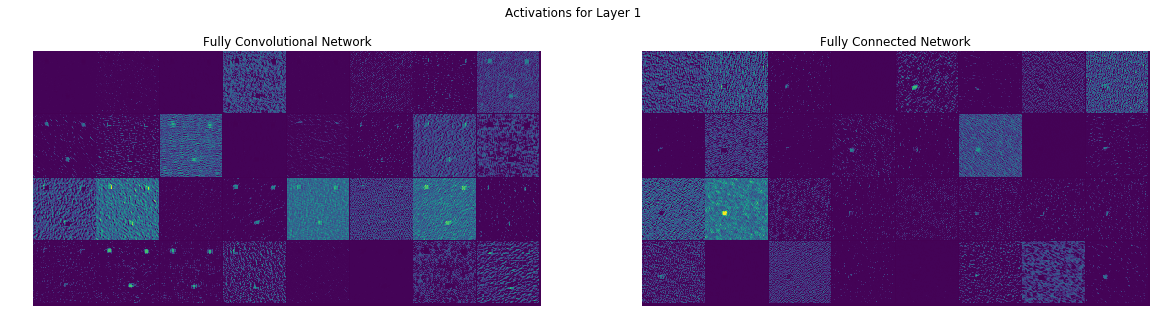

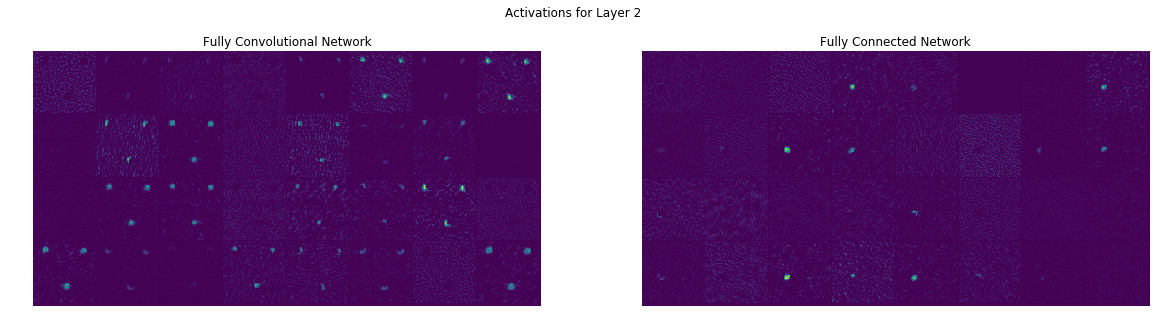

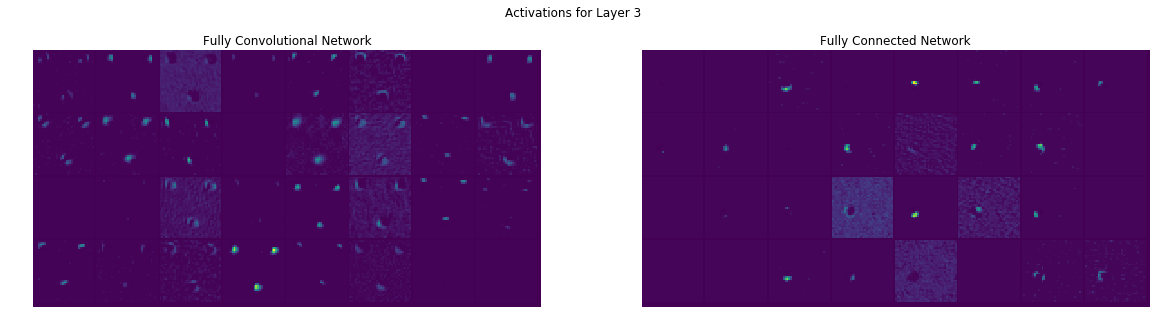

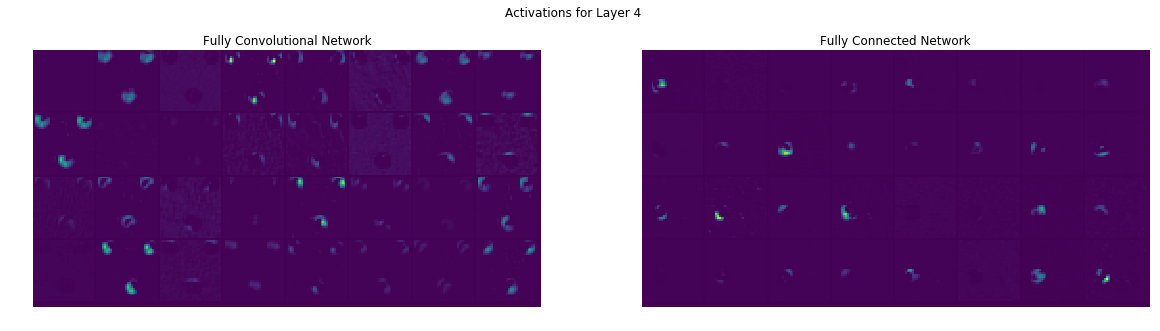

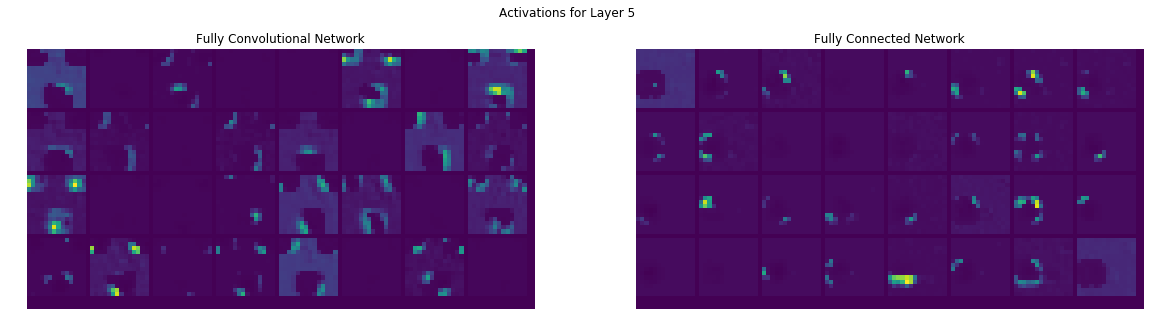

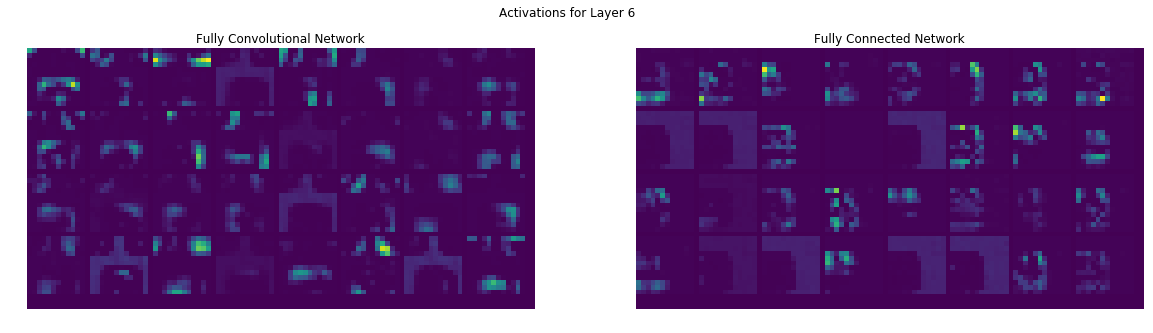

In [11]:
# What do the activations look like?
plt.rcParams['figure.figsize'] = (20,5)

idx = 0
rows = 4
cols = 8

for ii in range(1,7):
    conv_act = eval("conv.conv{}_act.cpu().data.numpy()".format(ii))
    connected_act = eval("connected.conv{}_act.cpu().data.numpy()".format(ii))
    
    counter = 0
    conv_img = np.zeros((rows*(1+conv_act.shape[2])+2,cols*(1+conv_act.shape[3])+1))
    connected_img = np.zeros((rows*(1+connected_act.shape[2])+2,cols*(1+connected_act.shape[3])+1))
    
    conv_act = (conv_act-np.min(conv_act))/(np.max(conv_act)-np.min(conv_act))
    connected_act = (connected_act-np.min(connected_act))/(np.max(connected_act)-np.min(connected_act))
    
    for r in range(rows):
        for c in range(cols):
            counter += 1
            conv_img[r*(conv_act.shape[2]+1):(1+r)*(1+conv_act.shape[2])-1,
                     c*(conv_act.shape[3]+1):(1+c)*(1+conv_act.shape[3])-1] = conv_act[idx,counter-1,:,:]
            connected_img[r*(connected_act.shape[2]+1):(1+r)*(1+connected_act.shape[2])-1,
                          c*(connected_act.shape[3]+1):(1+c)*(1+connected_act.shape[3])-1] = connected_act[idx,counter-1,:,:]
    plt.subplot(1,2,1)
    plt.imshow(conv_img)
    plt.axis('off')
    plt.title("Fully Convolutional Network")
    
    plt.subplot(1,2,2)
    plt.imshow(connected_img)
    plt.axis('off')
    plt.title("Fully Connected Network")
    
    plt.suptitle("Activations for Layer {}".format(ii))
    plt.show()
    

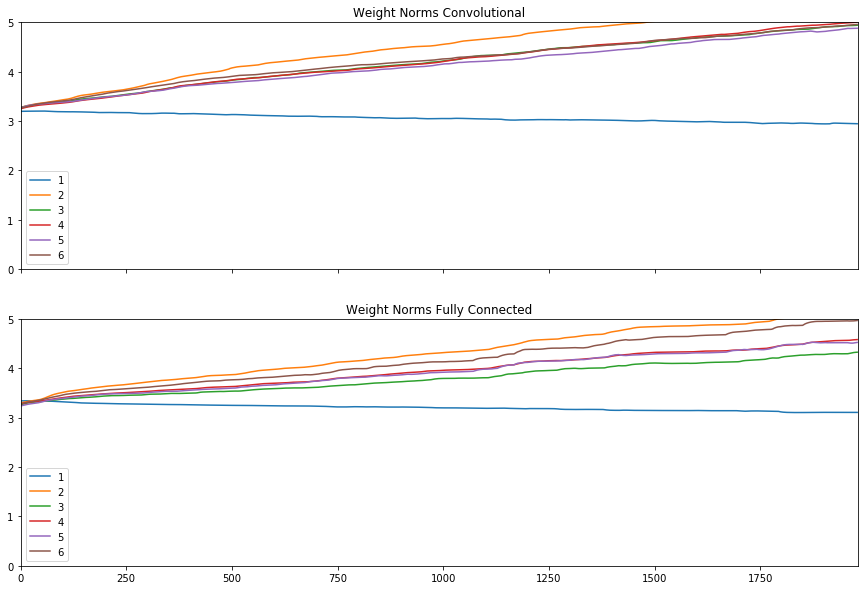

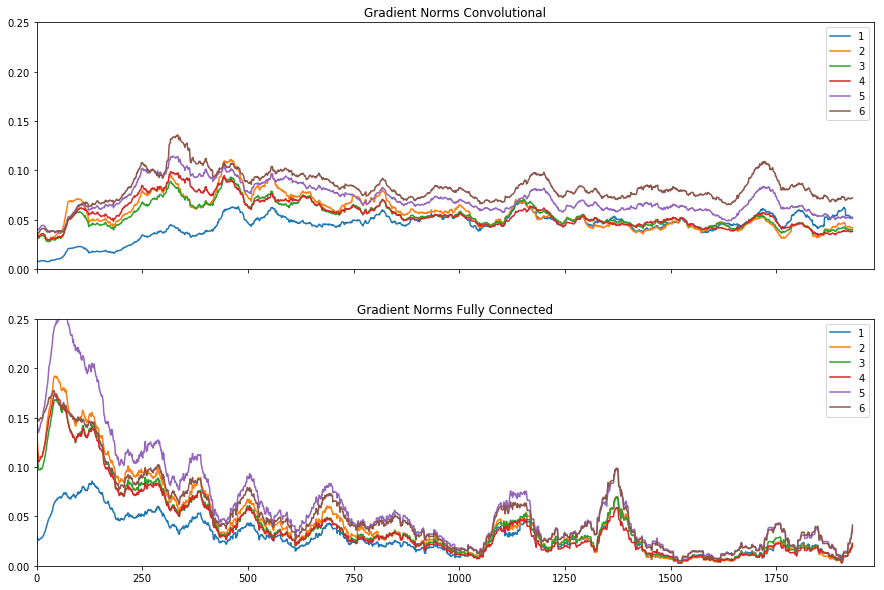

In [12]:
# That are the weight and gradient norms while training?

#clean up the data
wn_conv =  np.array([x for x in weight_norm_conv if x])
wn_connected =  np.array([x for x in weight_norm_connected if x])
gn_conv =  np.array([x for x in grad_norm_conv if x])
gn_connected =  np.array([x for x in grad_norm_connected if x])


plt.rcParams['figure.figsize'] = (15,10)
fig, ax = plt.subplots(2,1,sharex=True)

max_y =5
ax[0].plot(wn_conv[:,:6])
l = [str(l) for l in range(1,7)]
ax[0].legend(l)
ax[0].set_title("Weight Norms Convolutional")
ax[0].set_xlim(0,wn_conv.shape[0])
ax[0].set_ylim(0,max_y)

ax[1].plot(wn_connected)
ax[1].legend(l)
ax[1].set_title("Weight Norms Fully Connected")
ax[1].set_xlim(0,wn_conv.shape[0])
ax[1].set_ylim(0,max_y)
plt.show()


# That are the gradient norms while training?
fig, ax = plt.subplots(2,1,sharex=True)

max_y =0.25
ax[0].plot(moving_average(gn_conv[:,:6],n=50))
l = [str(l) for l in range(1,7)]
ax[0].legend(l)
ax[0].set_title("Gradient Norms Convolutional")
ax[0].set_xlim(0,gn_conv.shape[0])
ax[0].set_ylim(0,max_y)

ax[1].plot(moving_average(gn_connected,n=50))
ax[1].legend(l)
ax[1].set_title("Gradient Norms Fully Connected")
ax[1].set_xlim(0,gn_conv.shape[0])
ax[1].set_ylim(0,max_y)
plt.show()